### Importation des librairies 

In [ ]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             f1_score, roc_auc_score, precision_score, recall_score, 
                             roc_curve, auc)

import xgboost as xgb

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import BinaryResultsWrapper

import shap


In [ ]:
df = pd.read_csv("../data/hmeq.csv")

In [ ]:
df.drop(columns=["VALUE", "CLNO"], inplace=True) # Garder Mortdue car c'est une variable plus intéressante

In [ ]:
print(df.shape)

* check des valeurs manquantes 

In [3]:
df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
DEBTINC    1267
dtype: int64

* Supprimer les doublons 

In [ ]:
df = df.drop_duplicates()

#### Traitements des valeurs manquantes 

In [4]:
# Drop les duplicates et on supprime les lignes + 5 valeurs manquantes
nb_missing_value = df.isnull().sum(axis=1)
df = df[ nb_missing_value < 5
]

In [6]:
# Stratify pour équilibrer les modalité de la cible 

X = df.drop(columns=["BAD"])
y = df["BAD"]
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

* Imputation des valeurs manquantes 

In [7]:
def impute_by_value(X_train, X_test, col, value):
    X_train[col] = X_train[col].fillna(value)
    X_test[col] = X_test[col].fillna(value)
    return X_train, X_test

In [8]:
# Imputaion selon un sens "métier"
X_train, X_test = impute_by_value(X_train, X_test, "JOB", "Manquant")
X_train, X_test = impute_by_value(X_train, X_test, "REASON","Manquant")
X_train, X_test = impute_by_value(X_train, X_test, "YOJ", -1)

In [9]:
print(X_train.isnull().sum())
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

LOAN         0
MORTDUE    309
REASON       0
JOB          0
YOJ          0
DEROG      377
DELINQ     274
CLAGE       98
NINQ       216
DEBTINC    933
dtype: int64


In [10]:
# Gestion variables catégorielles
X_train = pd.get_dummies(X_train, columns=["REASON", "JOB"])
X_test = pd.get_dummies(X_test, columns=["REASON", "JOB"])

# Assurer que les colonnes de X_train et X_test sont identiques
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [11]:
X_train

,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,DEBTINC,REASON_DebtCon,REASON_HomeImp,REASON_Manquant,JOB_Manquant,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
928,9000,32539.0,5.0,NaN,NaN,NaN,NaN,42.368944,False,True,False,False,False,True,False,False,False,False
5244,28500,49461.0,21.0,0.0,0.0,210.025058,0.0,37.301764,True,False,False,False,False,False,True,False,False,False
4951,26100,73525.0,3.0,1.0,NaN,106.652298,0.0,22.508173,True,False,False,False,False,True,False,False,False,False
1187,10000,84000.0,30.0,0.0,0.0,325.633333,1.0,NaN,True,False,False,False,False,False,False,False,True,False
3524,18600,58992.0,4.0,0.0,0.0,103.504295,0.0,40.956598,True,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,9200,92395.0,24.0,0.0,0.0,130.376788,1.0,39.112150,False,True,False,False,False,True,False,False,False,False
2408,14500,35799.0,10.0,0.0,0.0,123.218105,1.0,18.324935,False,True,False,False,False,False,True,False,False,False
4444,23100,75837.0,9.0,0.0,0.0,377.291040,0.0,31.435316,False,False,True,False,False,False,True,False,False,False
492,7000,46225.0,16.0,0.0,4.0,219.133333,0.0,NaN,True,False,False,False,False,False,True,False,False,False


#### MODELE DE XGBOOST

* Optimisation des hyperparamètres avec un GridSearchCV

In [12]:
#  Les hyperparamètres choisis avec GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [100, 120, 150, 170, 200],
    'min_child_weight': [1, 5, 7],
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

# Nos meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres trouvés :", best_params)

Meilleurs hyperparamètres trouvés : {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 170, 'subsample': 0.7}


In [13]:
# Modèle optimal trouvé par GridSearchCV
best_model = grid_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

* Évaluation du modèle 

In [39]:
def eval_model(best_model, X_test, y_test, threshold=0.5):
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred_bin = (y_prob >= threshold).astype(int)
    
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_bin)
    f1 = f1_score(y_test, y_pred_bin)
    cr = classification_report(y_test, y_pred_bin)
    cm = confusion_matrix(y_test, y_pred_bin)
    
    print("AUC: ", auc)
    print("Accuracy: ", accuracy)
    print("F1: ", f1)
    print(cr)
    print(cm)

eval_model(best_model, X_test, y_test)

AUC:  0.9571973827699018
Accuracy:  0.9135371179039301
F1:  0.7637231503579952
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       917
           1       0.84      0.70      0.76       228

    accuracy                           0.91      1145
   macro avg       0.88      0.83      0.86      1145
weighted avg       0.91      0.91      0.91      1145

[[886  31]
 [ 68 160]]


* Rajout de l'optimisation de seuil 

/Users/maro/Library/Caches/pypoetry/virtualenvs/scoringhmeq-C4ofPLZf-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Meilleur Cutoff : 0.30 avec un F1 Score de : 0.81


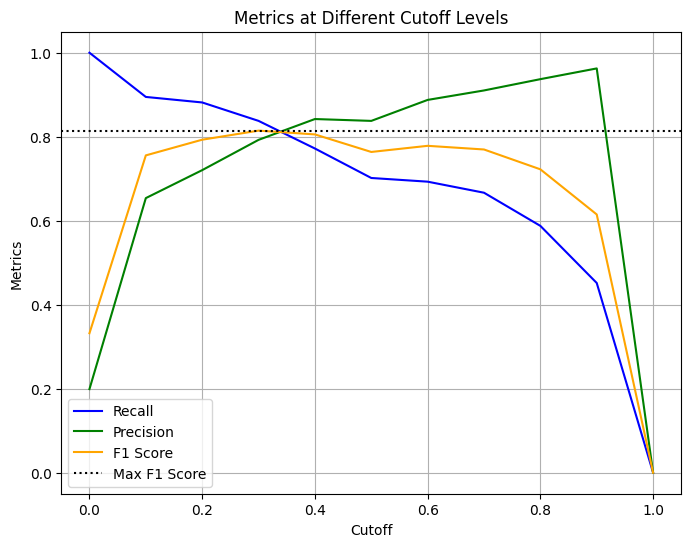

In [40]:
# Optimisation du seuil

def cutoffs_graph(best_model, X_test, y_test):
    recalls = []
    precisions = []
    f1_scores = []
    cutoffs = []
    
    # Probabilités pour la classe positive (BAD=1)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # Calcul des métriques pour différents seuils
    for cutoff in np.arange(0, 1.1, 0.1):  
        y_pred = (y_prob >= cutoff).astype(int)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        cutoffs.append(cutoff)
        recalls.append(recall)
        precisions.append(precision)
        f1_scores.append(f1)

    # Trouver le meilleur cutoff basé sur le F1 score
    best_f1_index = np.argmax(f1_scores)
    best_cutoff = cutoffs[best_f1_index]
    best_f1_value = f1_scores[best_f1_index]
    
    
    print(f"Meilleur Cutoff : {best_cutoff:.2f} avec un F1 Score de : {best_f1_value:.2f}") # Le meilleur cutoff

    
    plt.figure(figsize=(8, 6))
    plt.plot(cutoffs, recalls, label="Recall", color="blue")
    plt.plot(cutoffs, precisions, label="Precision", color="green")
    plt.plot(cutoffs, f1_scores, label="F1 Score", color="orange")
    plt.axhline(y=max(f1_scores), color="black", linestyle=":", label="Max F1 Score")

    plt.xlabel("Cutoff")
    plt.ylabel("Metrics")
    plt.title("Metrics at Different Cutoff Levels")
    plt.legend()
    plt.grid()
    plt.show()

cutoffs_graph(best_model, X_test, y_test)
eval_model(best_model, X_test, y_test, 0.30)

* Evaluation du modèle après optimisation du seuil

In [41]:
eval_model(best_model, X_test, y_test, 0.30)

AUC:  0.9571973827699018
Accuracy:  0.9240174672489083
F1:  0.814498933901919
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       917
           1       0.79      0.84      0.81       228

    accuracy                           0.92      1145
   macro avg       0.88      0.89      0.88      1145
weighted avg       0.93      0.92      0.92      1145

[[867  50]
 [ 37 191]]


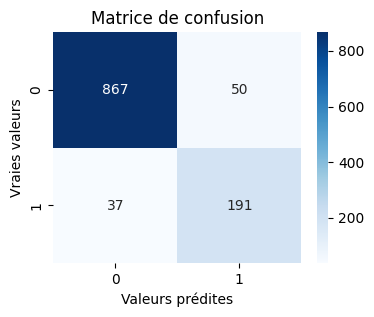

In [44]:
# Matrice de confusion après optimisation du seuil

y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.3).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()

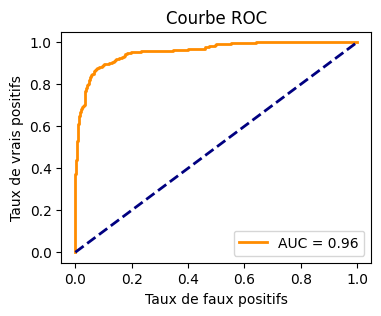

In [46]:
# Calcul  ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

### SHAPLEY VALUES

In [24]:
best_model.fit(X_train, y_train)

# Explicabilité avec SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)

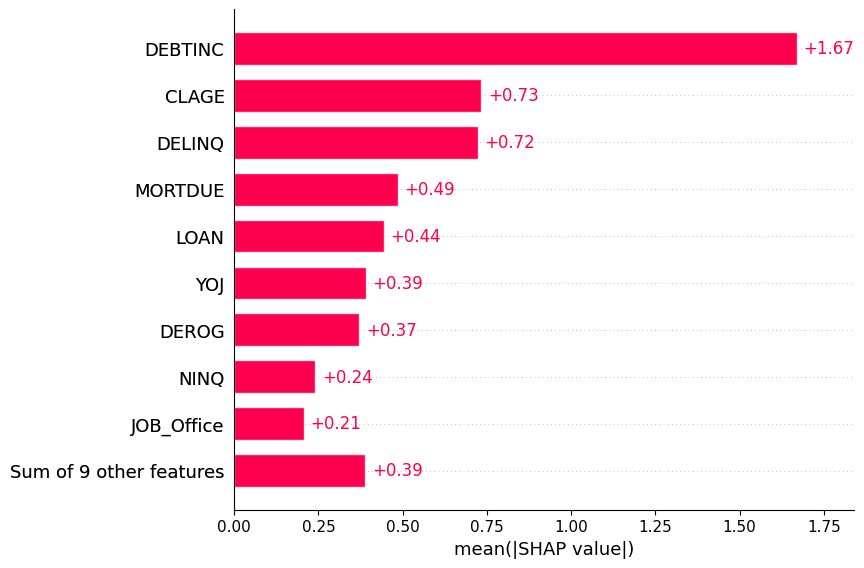

In [25]:
# Résumé global des effets de chaque caractéristique
shap.plots.bar(shap_values)

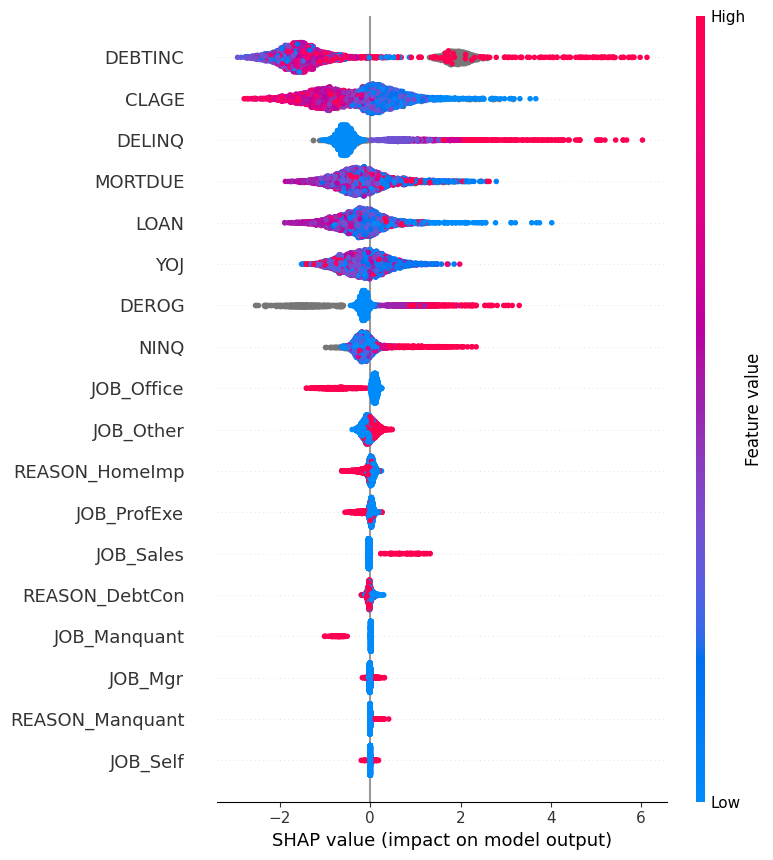

In [19]:
# Visualisation des effets locaux (pour chaque prédiction individuelle)
shap.summary_plot(shap_values, X_train)


--- Observation 321 ---
Prédiction du modèle pour l'observation 321 (probabilité d'appartenir à la classe positive) : 0.02845066413283348


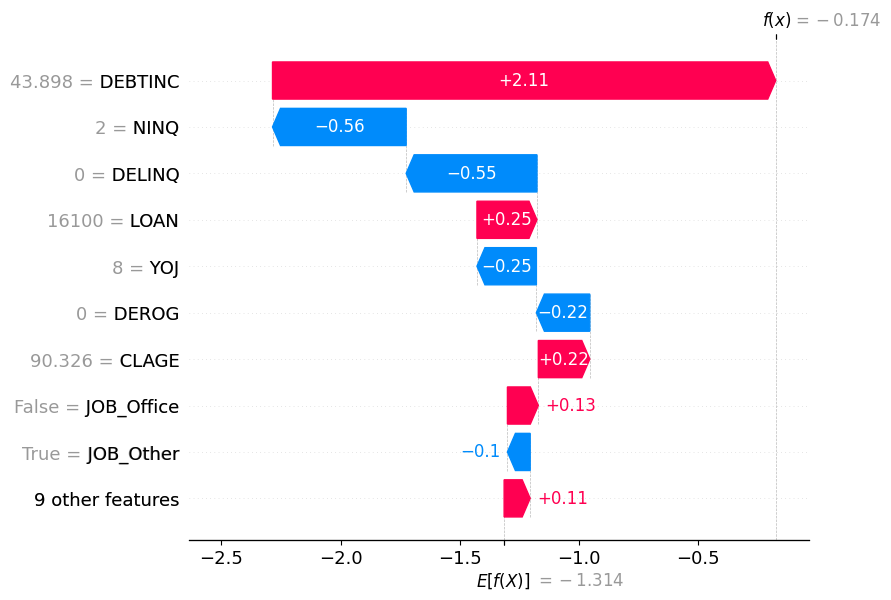


--- Observation 923 ---
Prédiction du modèle pour l'observation 923 (probabilité d'appartenir à la classe positive) : 0.003724414622411132


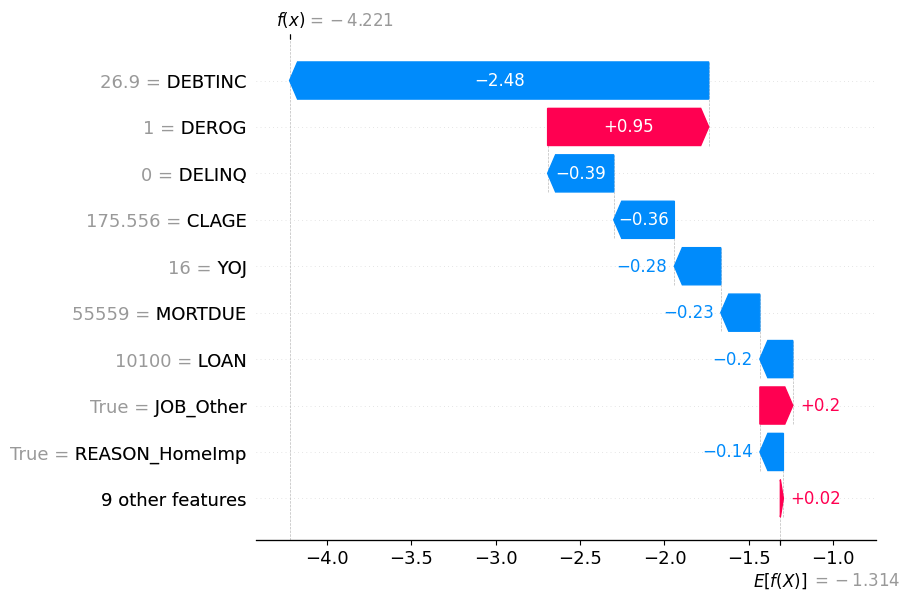


--- Observation 385 ---
Prédiction du modèle pour l'observation 385 (probabilité d'appartenir à la classe positive) : 0.05082385987043381


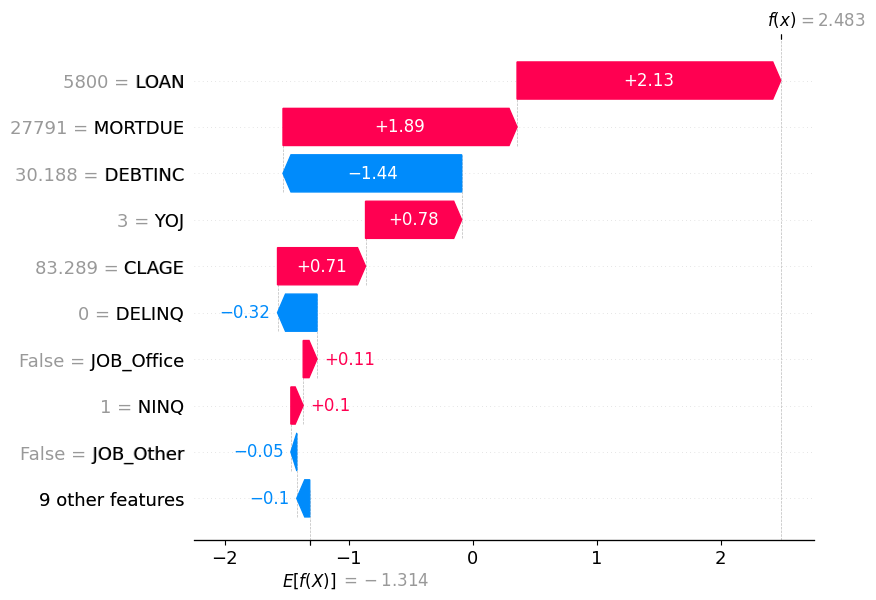


--- Observation 209 ---
Prédiction du modèle pour l'observation 209 (probabilité d'appartenir à la classe positive) : 0.21659016609191895


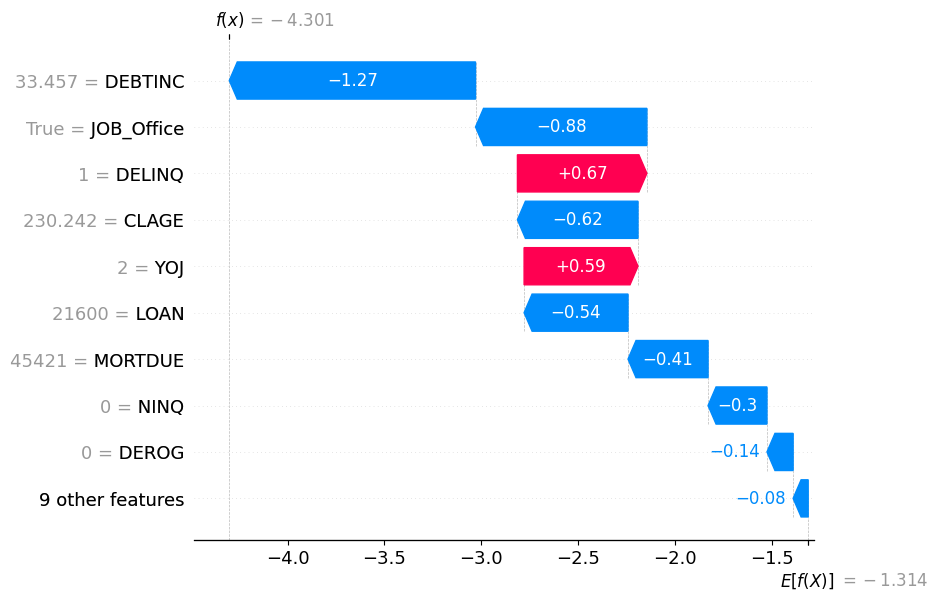


--- Observation 864 ---
Prédiction du modèle pour l'observation 864 (probabilité d'appartenir à la classe positive) : 0.09190654009580612


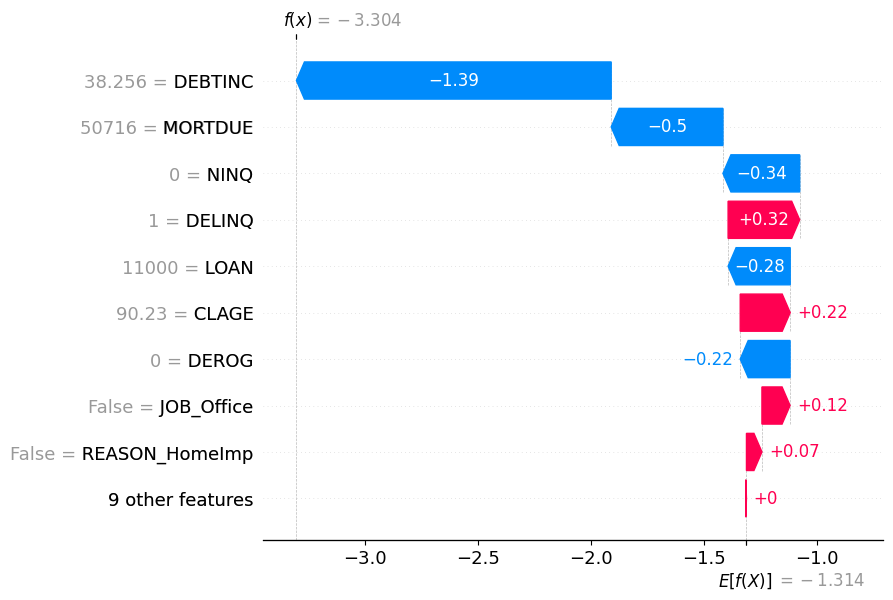


--- Observation 277 ---
Prédiction du modèle pour l'observation 277 (probabilité d'appartenir à la classe positive) : 0.005476907826960087


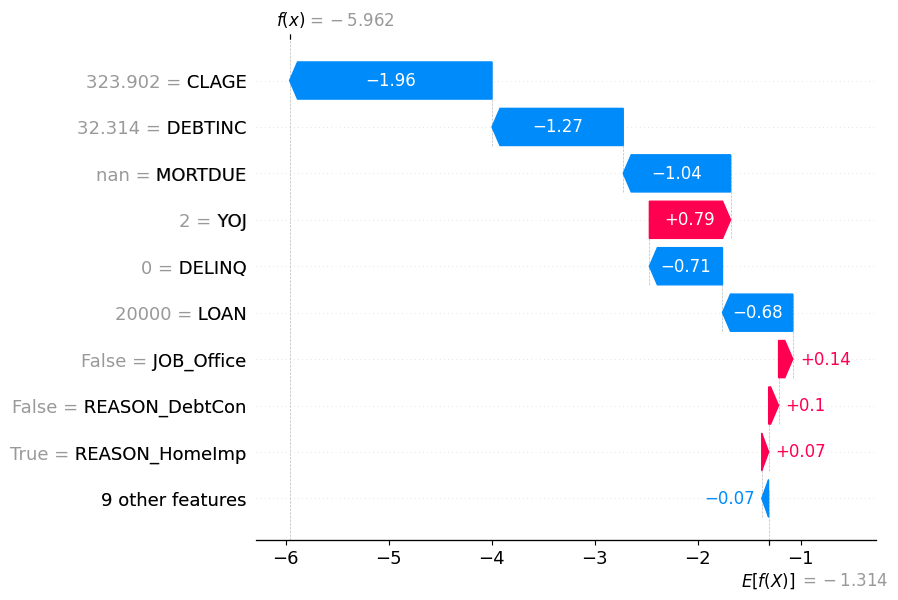


--- Observation 224 ---
Prédiction du modèle pour l'observation 224 (probabilité d'appartenir à la classe positive) : 0.28522950410842896


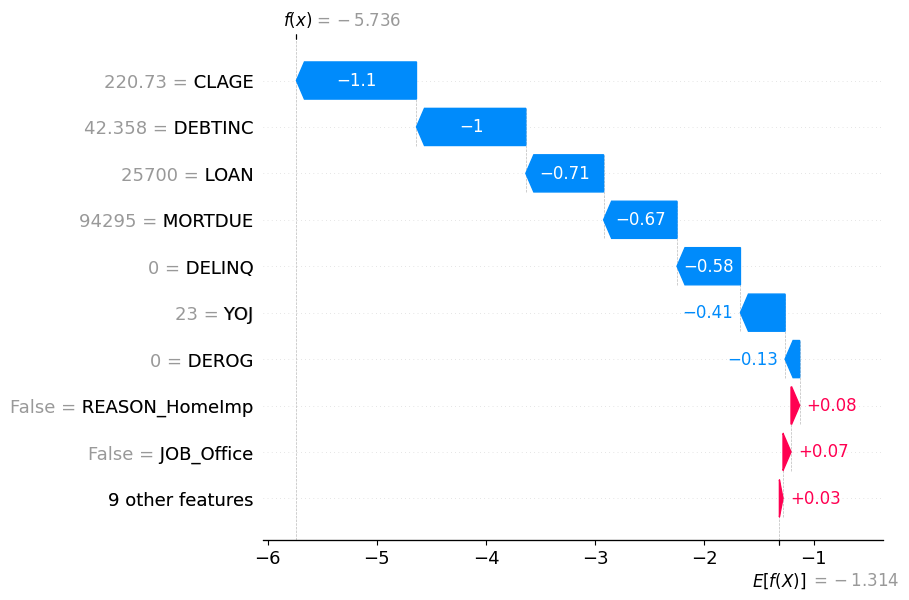


--- Observation 851 ---
Prédiction du modèle pour l'observation 851 (probabilité d'appartenir à la classe positive) : 0.7566713690757751


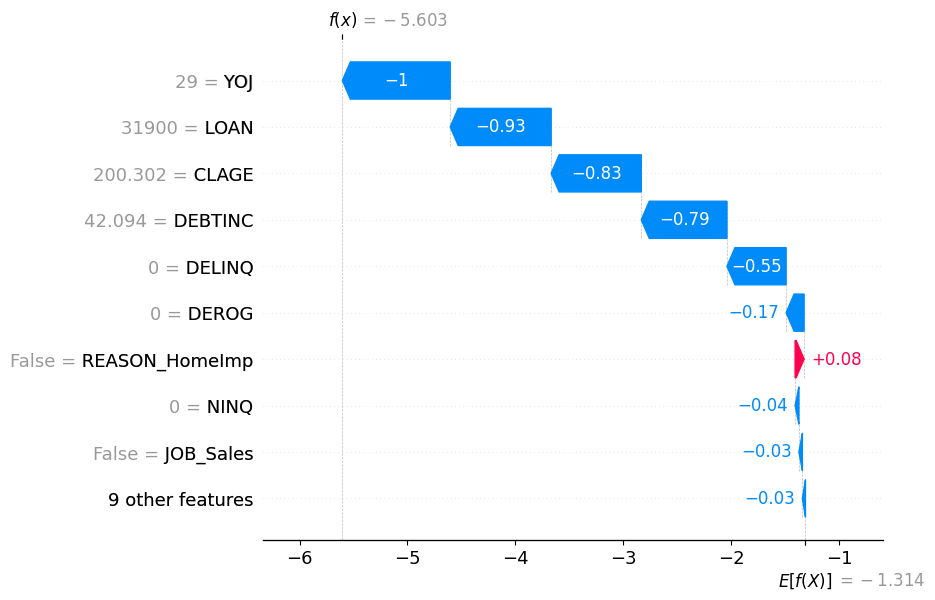


--- Observation 874 ---
Prédiction du modèle pour l'observation 874 (probabilité d'appartenir à la classe positive) : 0.006238260772079229


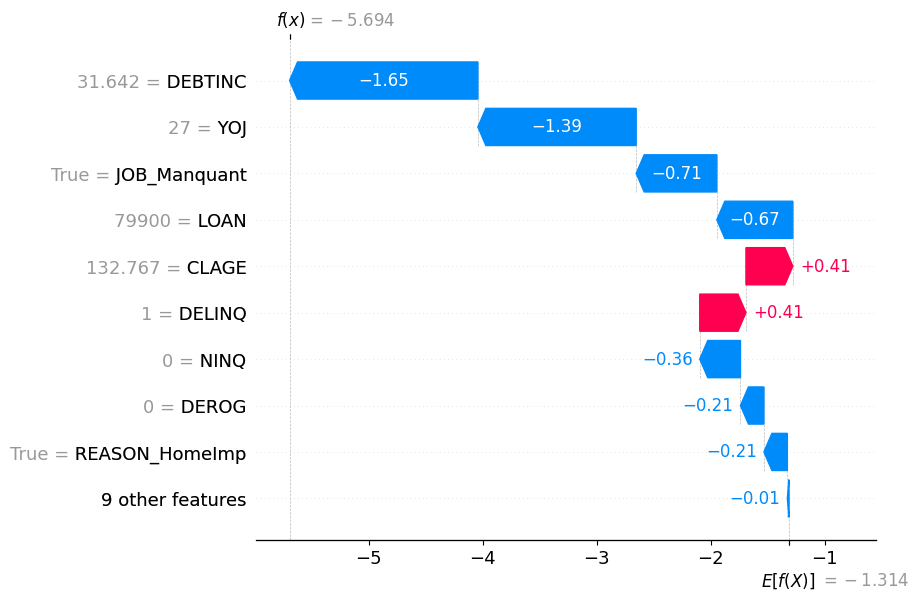


--- Observation 542 ---
Prédiction du modèle pour l'observation 542 (probabilité d'appartenir à la classe positive) : 0.011258778162300587


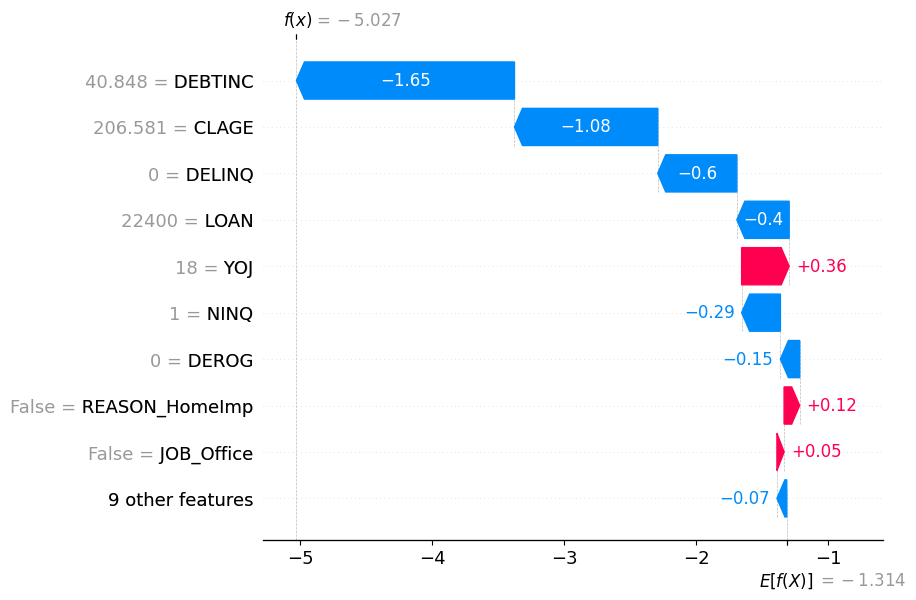


--- Observation 565 ---
Prédiction du modèle pour l'observation 565 (probabilité d'appartenir à la classe positive) : 0.019481709226965904


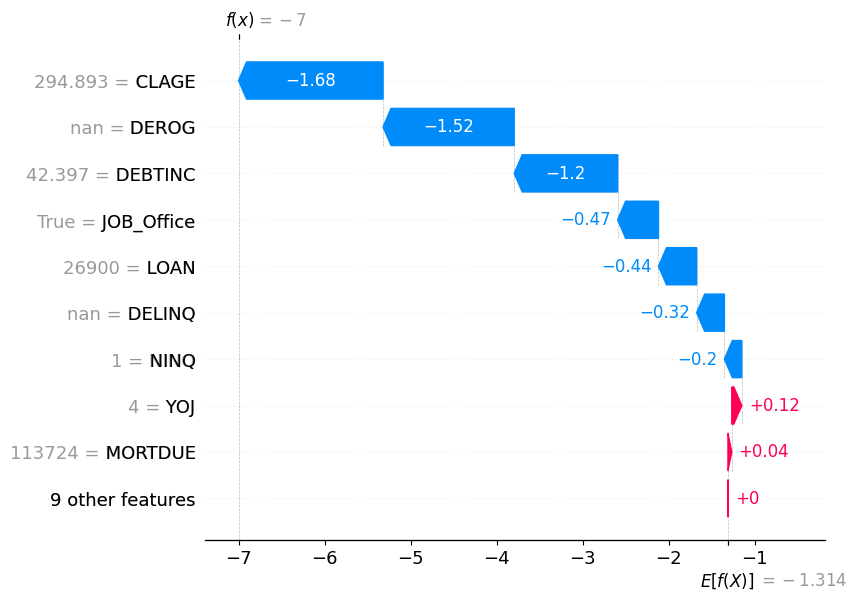


--- Observation 613 ---
Prédiction du modèle pour l'observation 613 (probabilité d'appartenir à la classe positive) : 0.07502511888742447


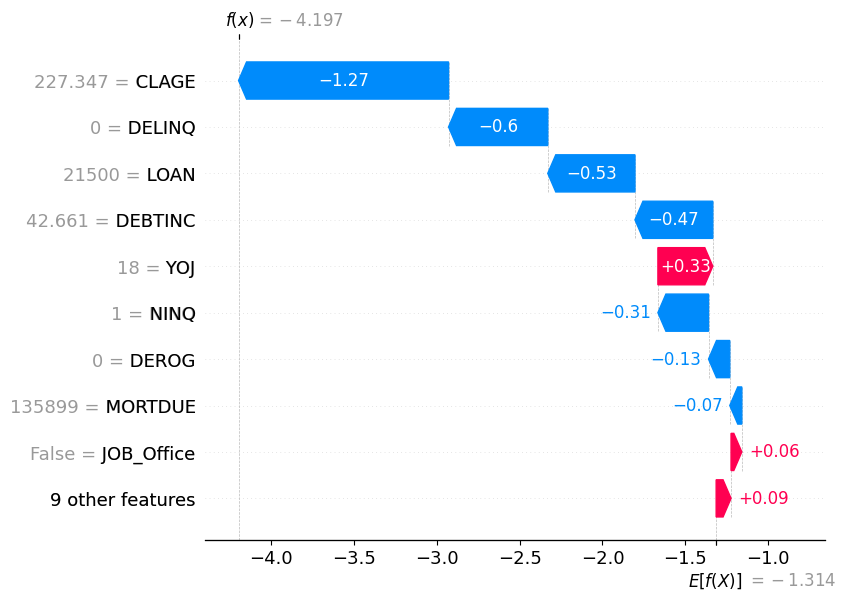


--- Observation 374 ---
Prédiction du modèle pour l'observation 374 (probabilité d'appartenir à la classe positive) : 0.856576681137085


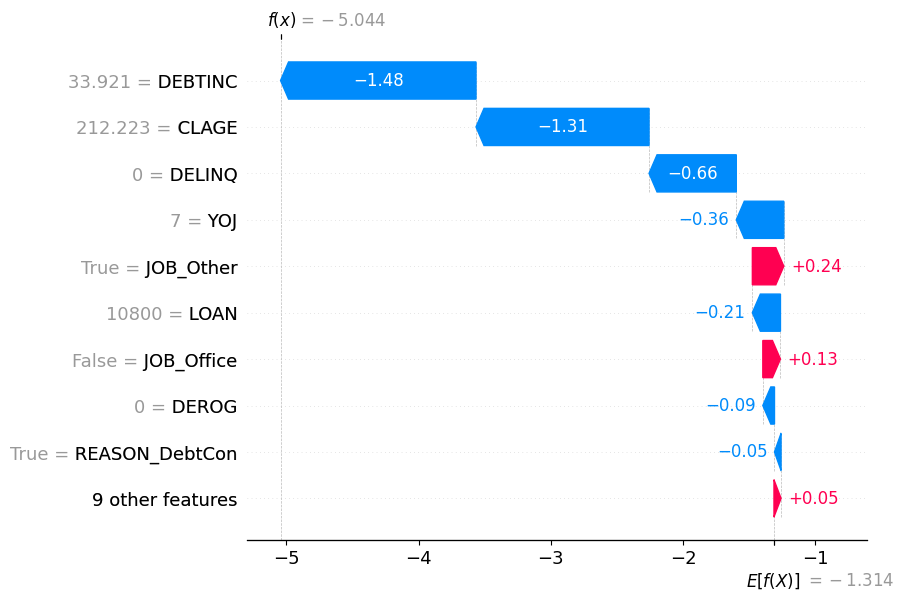


--- Observation 587 ---
Prédiction du modèle pour l'observation 587 (probabilité d'appartenir à la classe positive) : 0.0088758934289217


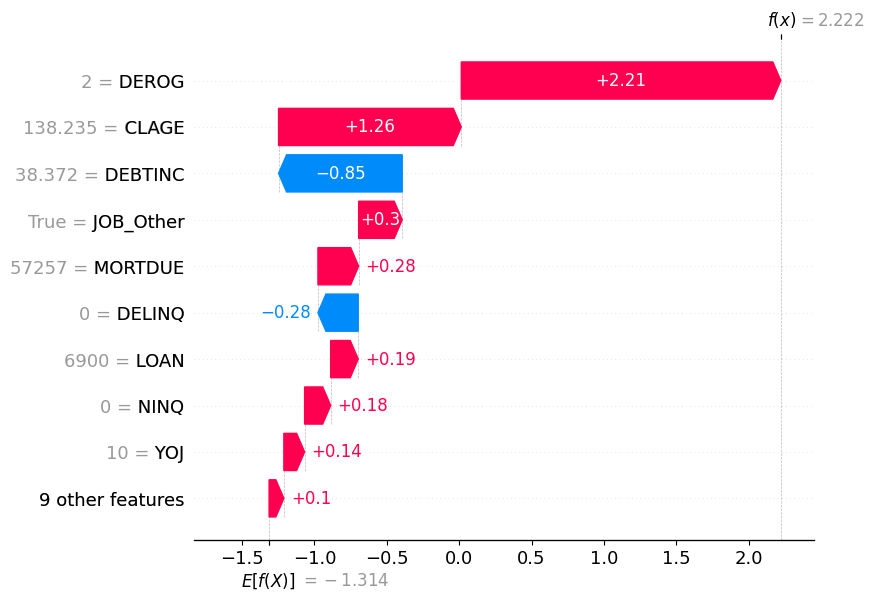


--- Observation 234 ---
Prédiction du modèle pour l'observation 234 (probabilité d'appartenir à la classe positive) : 0.8063681125640869


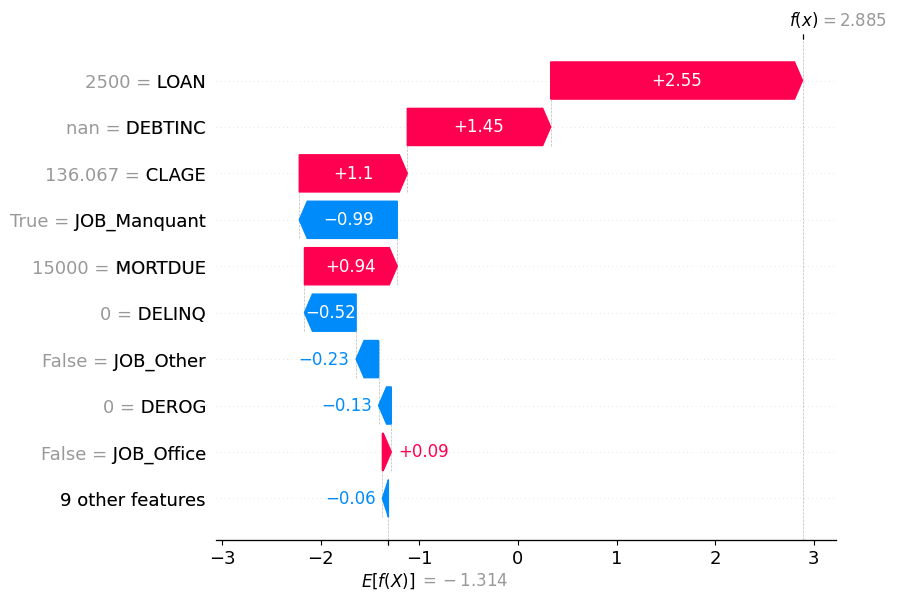


--- Observation 334 ---
Prédiction du modèle pour l'observation 334 (probabilité d'appartenir à la classe positive) : 0.013484746217727661


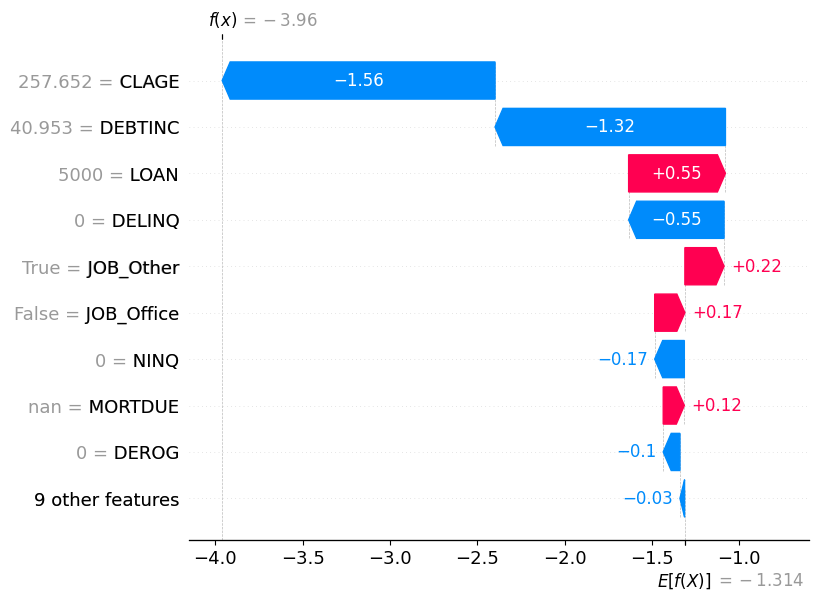


--- Observation 186 ---
Prédiction du modèle pour l'observation 186 (probabilité d'appartenir à la classe positive) : 0.9192736148834229


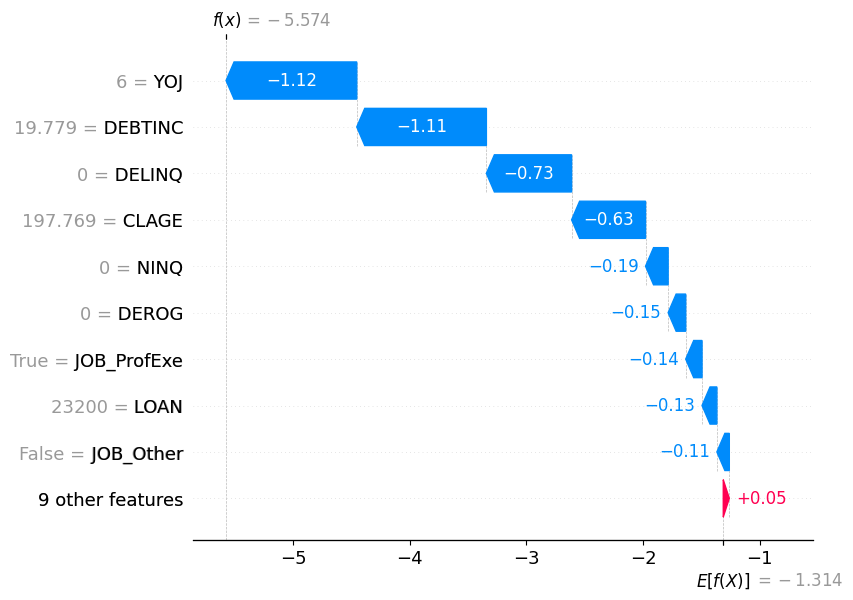


--- Observation 172 ---
Prédiction du modèle pour l'observation 172 (probabilité d'appartenir à la classe positive) : 0.004077766090631485


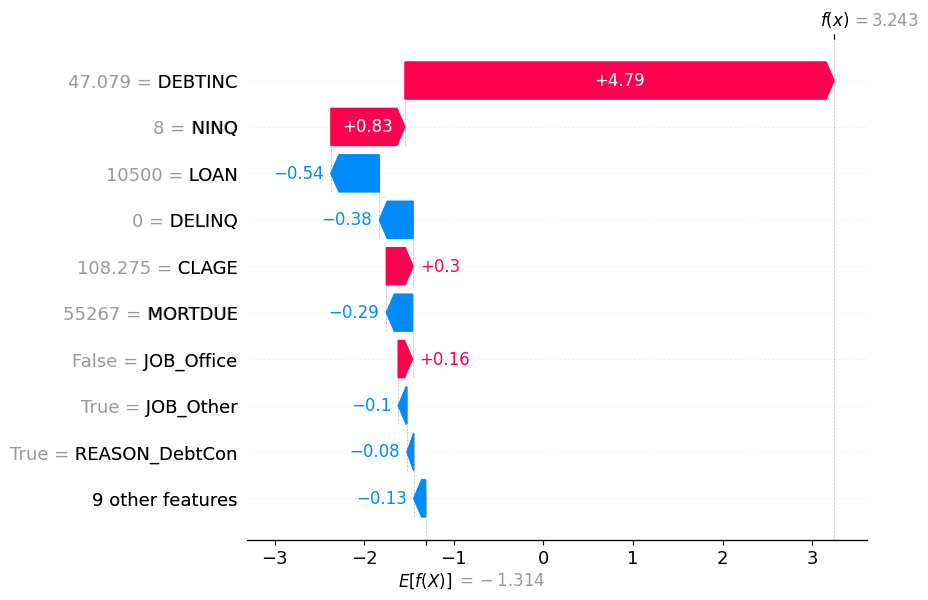


--- Observation 289 ---
Prédiction du modèle pour l'observation 289 (probabilité d'appartenir à la classe positive) : 0.9399228096008301


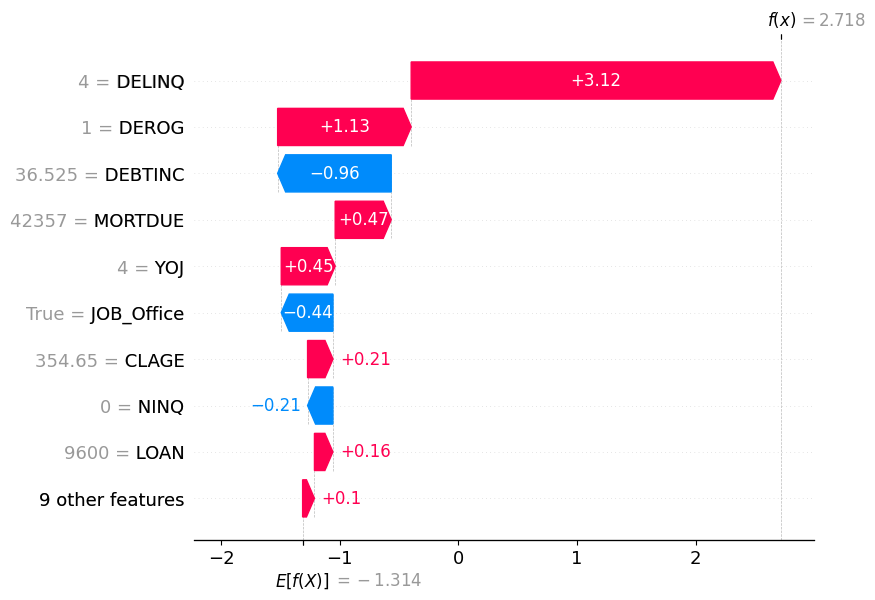


--- Observation 353 ---
Prédiction du modèle pour l'observation 353 (probabilité d'appartenir à la classe positive) : 0.9940574169158936


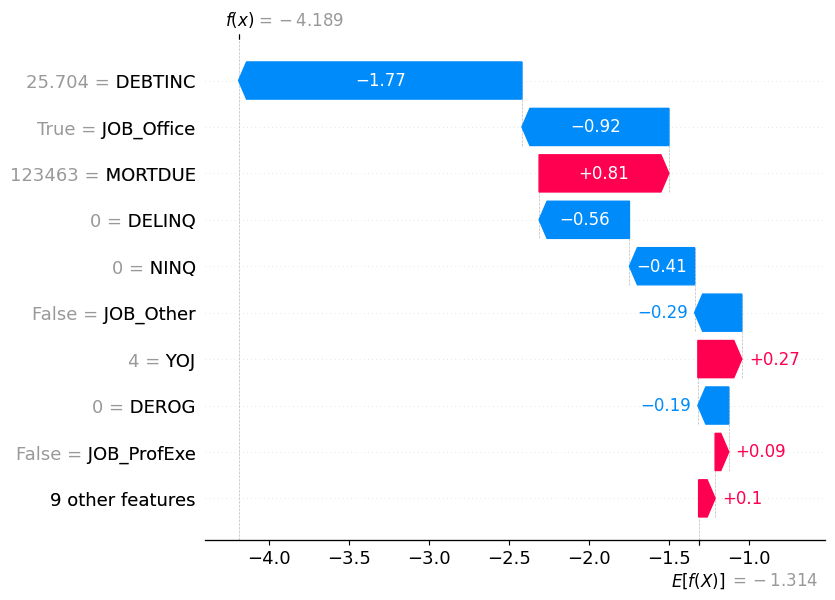

In [27]:
random_indices = random.sample(range(0, 1000), 20)
for idx in random_indices:
    print(f"\n--- Observation {idx} ---")
    
    predicted_proba = best_model.predict_proba(X_test.iloc[[idx]])[0][1]
    print(f"Prédiction du modèle pour l'observation {idx} (probabilité d'appartenir à la classe positive) : {predicted_proba}")
    
    shap.plots.waterfall(shap_values[idx])